#### Задание 1. A/B–тестирование
1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

__groups.csv__ - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
__groups_add.csv__ - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
__active_studs.csv__ - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
__checks.csv__ - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [113]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [83]:
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/', sep = ';')
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/', sep = ',')
activ_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get', sep = ';')
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get', sep = ';')

Проведем разведанализ наших данных

In [84]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [85]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [86]:
groups.grp.unique()

array(['B', 'A'], dtype=object)

In [87]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

В размерах выборок видим существенную разницу - в тестовой количество наблюдений в четыре раза больше, чем в контрольной. Неоднозначное решение о разбивке групп, с предоставлением такого приоритета тестовой.

In [88]:
activ_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [89]:
activ_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [90]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [91]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Перед тем, как приступить к проведению тестов, определимся с метрикой. Нам необходимо выбрать метрику для, которая бы учитывала как конверсию пользователя, так и непосредственнос финансовую составляющую. Наиболее подходящим выбором в данном случае кажется средний доход на пользователя (ARPU), так как метрика учитывает, как конверсию, так и средний чек (ARPU=Конверсия⋅ARPPU, при этом ARPPU="Число повторных покупок" * "Средний чек"). Если мы выберем в качестве целевой метрики только конверсию, то никак не отследим, насколько изменился доход от наших нововведений, а выбор ARPPU (дохода на платящего пользователя) или среднего чека не будет учитывать конверсию. 

Пропусков в данных не обнаружено, типы данных не конфликтуют с логикой столбцов. Для дальнейшей работы сджойним три имеющиеся таблицы в одну

In [92]:
groups = groups.rename(columns={'id': 'student_id'})
groups.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [93]:
activ_studs.merge(checks, how='left', on='student_id').rev.value_counts().sum()

392

In [94]:
groups.merge(checks, how='left', on='student_id').rev.value_counts().sum()

540

In [95]:
392 / 540

0.725925925925926

Видим, что при джойне таблицы активных пользователей с таблицей оплат мы теряем почти 150 (28%) пользователей, оплативших курсы. Это может быть связано как с ошибкой сбора данных, так и с тем, что часть старых пользователей оплатила курсы по ранее сохраненной ссылке, либо же проплаты по каким-то причинам задержались.

Сджойним таблицы так, чтобы не потерять информацию о платежах и активных пользователях

In [98]:
activ_groups = activ_studs.merge(checks, how='outer', on='student_id')
activ_groups = activ_groups.merge(groups, how='left', on='student_id')
activ_groups.head()

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,NaN
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [99]:
activ_groups['grp'].value_counts(dropna=False)

B      6913
A      1564
NaN      13
Name: grp, dtype: int64

In [100]:
activ_groups[activ_groups['grp'].isna() == True]

,student_id,rev,grp
1,5723133,NaN,NaN
111,5951797,NaN,NaN
632,5730382,NaN,NaN
2662,5739944,NaN,NaN
3830,5945085,NaN,NaN
4900,5700613,NaN,NaN
5254,5729371,NaN,NaN
5746,5777081,NaN,NaN
7413,5740903,1900.0,NaN
7505,5760471,NaN,NaN


В итоговой таблице остались 13 неопределенных пользователей, у одного из которых есть проплата. Посмотрим какие уникальные варианты оплаты есть в кадой группе.

In [101]:
activ_groups[activ_groups['grp'] == 'A']['rev'].unique()

array([  nan, 1530., 1980.,  580., 2910.,  690., 3660.,  840.,  590.,
        290., 1180.,  199., 1140.,  489., 2890., 1160., 2820., 2900.,
       1039., 1830., 2220.,  990.,  870.,  398.])

In [102]:
activ_groups[activ_groups['grp'] == 'A']['rev'].value_counts()

290.0     31
690.0     19
199.0      7
580.0      6
990.0      6
1140.0     5
590.0      5
1530.0     3
840.0      3
3660.0     3
1980.0     2
489.0      2
1160.0     2
2820.0     2
2910.0     2
398.0      2
1180.0     1
2890.0     1
2900.0     1
1039.0     1
1830.0     1
2220.0     1
870.0      1
Name: rev, dtype: int64

In [103]:
activ_groups[activ_groups['grp'] == 'B']['rev'].unique()

array([      nan, 1900.0001, 1900.    ,  690.    ,  290.    ,  990.    ,
        199.    ,  398.    ,  580.    , 1140.    ,  870.    , 3660.    ,
       1388.    , 1530.    ,  590.    ,  840.    , 2890.    ,  489.    ,
       1980.    , 1729.    , 1160.    , 1050.    , 4650.    , 2099.    ,
        796.    , 1339.    , 2190.    , 2910.    , 3040.    , 3260.    ,
       2220.    , 1968.    ,  880.    ,  597.    ,  630.    , 1180.    ])

In [104]:
activ_groups[activ_groups['grp'] == 'B']['rev'].value_counts()

1900.0000    96
290.0000     63
690.0000     59
199.0000     39
1900.0001    36
990.0000     35
840.0000     24
1140.0000    20
580.0000      9
398.0000      7
590.0000      6
870.0000      5
1530.0000     5
2099.0000     3
2890.0000     3
2910.0000     2
1980.0000     2
3660.0000     2
1729.0000     1
630.0000      1
597.0000      1
880.0000      1
1968.0000     1
2220.0000     1
3260.0000     1
3040.0000     1
489.0000      1
2190.0000     1
1339.0000     1
796.0000      1
1388.0000     1
4650.0000     1
1050.0000     1
1160.0000     1
1180.0000     1
Name: rev, dtype: int64

Посмотрим на распределение переменной 'rev'. 

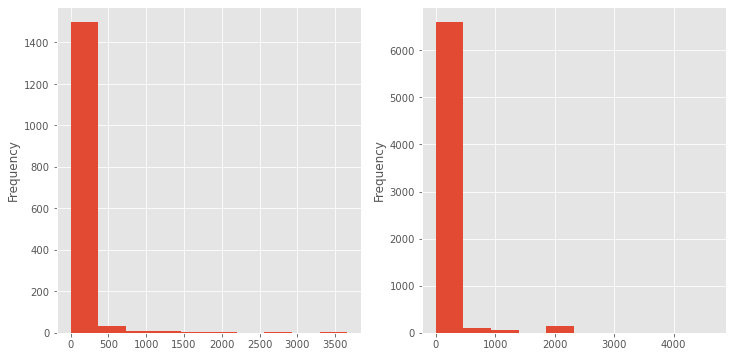

In [190]:
plt.figure(figsize=(12, 6))

plt.subplot (1, 2, 1)
activ_groups[activ_groups['grp'] == 'A']['rev'].plot(kind='hist')

plt.subplot (1, 2, 2)
activ_groups[activ_groups['grp'] == 'B']['rev'].plot(kind='hist')

plt.show()

Отсечем нулевые значения, которые мешают нам оценить распределение ненулевых

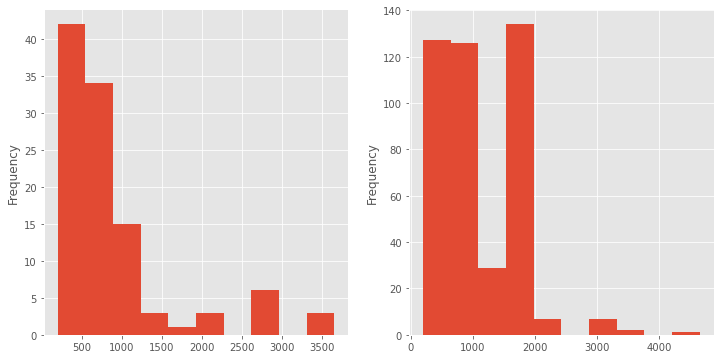

In [106]:
plt.figure(figsize=(12, 6))

plt.subplot (1, 2, 1)
activ_groups[(activ_groups['grp'] == 'A') & (activ_groups['rev'] != 0)]['rev'].plot(kind='hist')

plt.subplot (1, 2, 2)
activ_groups[(activ_groups['grp'] == 'B') & (activ_groups['rev'] != 0)]['rev'].plot(kind='hist')

plt.show()

Очевидно, что в тестовой группе гораздо больше возможных вариантов оплаты. Возникает вопрос о том, насколько релевантным было разбиение студентов на группы, в группе "B" существенно более высокая вариативность размера оплаты. Особенно выделяется частота покупок по цене 1900. Такой всплеск мог быть вызван, например, существенной скидкой на курс, либо какой-нибудь промоакцией вроде "купи два по цене одного". Если к нам попали пользователи с промоакцией, которых нет в контрольной группе, то это существенно повлияет на эксперимент, проводить который следует при полном равенстве остальных параметров за исключением целевого.

Также мы видим, что студент с неопределенной группой, оплативший курс за 1900, вероятнее всего относится к группе "В". Предположим, наихудший для нас вариант - все студенты с неопределеной группой принадлежат тестовой группе. Такой вариант уменьшит значение конверсии, что отразится и на других метриках.

In [139]:
activ_groups['grp'] = activ_groups['grp'].fillna('B')

In [140]:
activ_groups.shape[0] == activ_groups['student_id'].nunique()

True

Количество уникальных значений student_id совпадает с длиной таблицы, а значит это это позволяет нам рассчитать ARPPU (средний доход на активного пользователя), просто использовав mean(), поскольку значения NaN учитываться в рассчете не будут.  Теоретически это будет и частный случай среднего чека, поскольку в наших данных у каждого пользователя по одной транзакции.

In [141]:
display(activ_groups[activ_groups['grp'] == 'A']['rev'].mean(),
        activ_groups[activ_groups['grp'] == 'B']['rev'].mean())

58.8849104859335

69.4816638174993

ARPPU в тестовой группе заметно выше, чем в контрольной. Посмотрим, отличаются ли значения конверсии в группах. Для дальнейших рассчетов нам потребуется заполнить NaN нулями и создать дополнительное поле 'action', фиксирующими факт целевого действия пользователя: 0 - покупки не было, 1 - покупка была.

In [142]:
activ_groups['rev'] = activ_groups['rev'].fillna(0)
activ_groups['action'] = activ_groups['rev'].apply(lambda x: 1 if x > 0 else 0)
activ_groups.head()

,student_id,rev,grp,action
0,581585,0.0,A,0
1,5723133,0.0,B,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0


In [143]:
display(activ_groups[activ_groups['grp'] == 'A']['action'].mean(),
        activ_groups[activ_groups['grp'] == 'B']['action'].mean())

0.06841432225063938

0.0626624314178458

Конверсия в тестовой группе немного "просела" по сравнению с контрольной. Оценим ARPU, в данном случае это будет среднее значение переменной 'rev'.

In [144]:
display(activ_groups[activ_groups['grp'] == 'A']['rev'].mean(),
        activ_groups[activ_groups['grp'] == 'B']['rev'].mean())

58.8849104859335

69.4816638174993

ARPU в тестовой группе существенно вырос 

Очевидно, что распределение признака ненормальное. Использование классических критериев оценки требует ряда определеных допущений, таких как одинаковая дисперсия, одинаковый размер выборки, либо одинаковая дисперсия, что может повлиять на мощность критерия. Использование непараметрического критерия Манна-Уитни в данном случае нецелесообразно, поскольку он сравнивает равенство распределений, а мы хотим оценить равенство средних значений. Кроме того, у нас огромное количество нулевых значений в обоих выборках, что негативно скажется на его мощности. В нашем случае наиболее подходящим вариантом для проверки гипотезы кажется использование бутстрэпа. 

In [145]:
control_group = activ_groups[activ_groups['grp'] == 'A']['rev']
test_group = activ_groups[activ_groups['grp'] == 'B']['rev']

In [146]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_2)-statistic(samples_1)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value,
           }

  0%|          | 0/10000 [00:00<?, ?it/s]

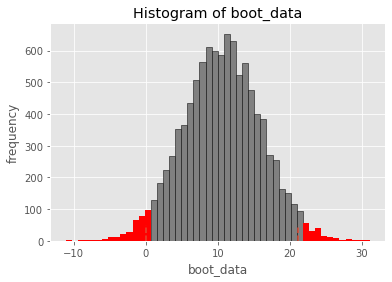

In [147]:
booted_data = get_bootstrap(control_group, test_group)

In [148]:
booted_data["p_value"]

0.04865349842230263

In [149]:
booted_data["quants"]

,0
0.025,0.023373
0.975,21.136945


Результаты теста позволяют нам отвергнуть нулевую теорию о равенстве средних, поскольку доверительный интервал разницы средних не включает ноль. При этом P-уровень значимости ниже 0.05, тем не менее результат очень близок к пороговому значению

При таких результатах мы можем рекомендовать раскатывать изменения на всех пользователей при условии, что тестовые группы действительно были разбиты корректно, и мы на вход действительно получили релевантные данные.

Посмотрим изменят ли ситуацию добавление дополнительных данных. 

In [150]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [151]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [152]:
groups_add = groups_add.rename(columns={'id':'student_id'})

In [153]:
groups_total = pd.concat([groups, groups_add], ignore_index=True)

Проверим совпадает ли длина полученного датафрейма с длиной суммы двух исходных, а также проверим, уникальны ли значения id студентов

In [154]:
groups_total.shape[0] == groups.shape[0] + groups_add.shape[0]

True

In [155]:
groups_total['student_id'].duplicated().sum()

0

In [156]:
activ_groups = activ_studs.merge(checks, how='outer', on='student_id')
activ_groups = activ_groups.merge(groups_total, how='left', on='student_id')
activ_groups.head()

,student_id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B


In [157]:
activ_groups.grp.unique()

array(['A', 'B'], dtype=object)

Дополнительные даные внесли некоторые исправления в тестовые данне, теперь мы видим, что не осталось студентов с неопределенной группой. Глянем на конверсию.

In [158]:
activ_groups['rev'] = activ_groups['rev'].fillna(0)
activ_groups['action'] = activ_groups['rev'].apply(lambda x: 1 if x > 0 else 0)

In [159]:
display(activ_groups[activ_groups['grp'] == 'A']['action'].mean(),
        activ_groups[activ_groups['grp'] == 'B']['action'].mean())

0.06828334396936822

0.06268958543983821

Показатели конверсии не сильно отличаются от рассчитанных ранее. Проведем тесты с обновленными данными.

In [160]:
control_group = activ_groups[activ_groups['grp'] == 'A']['rev']
test_group = activ_groups[activ_groups['grp'] == 'B']['rev']

  0%|          | 0/10000 [00:00<?, ?it/s]

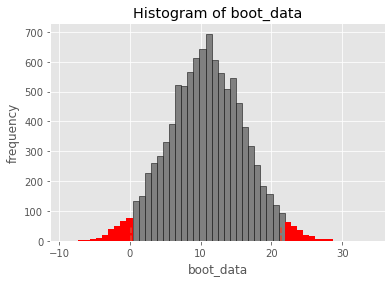

In [161]:
booted_data = get_bootstrap(control_group, test_group)

In [162]:
booted_data["p_value"]

0.04573206219356632

In [163]:
booted_data["quants"]

,0
0.025,0.125835
0.975,21.422744


Результаты теста существенно не изменились. Ноль по-прежнему не входит в доверительный интервал разницы средних двух выборок, а P-value ниже альфа-значения в 0.05, но все так же близок к пороговому значению. При более строгом значении альфа мы бы не смогли отвергнуть нулевую гипотезу.

__Резюме__: предложить раскатывать эксперимент на всех пользователей можно в том случае, если мы получили корректные данные в тестовой и контрольной группах. Этот момент следует уточнить у спеуциалиста, проводившего выборку данных. Отдельно стоит уточнить относительно платежей по 1600, которые выбиваются из  общей массы.

### SQL section

In [60]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

__2.1 Очень усердные ученики__

Дана таблица default.peas, содержащая данные о решении студентами заданий.
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной". Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [61]:
sql = ''' 
        SELECT uniq(t.st_id) AS quantity_
        FROM (
                SELECT 
                    st_id,
                    toStartOfMonth(timest) AS month_,
                    countIf(correct = 1) AS sum_result
                FROM default.peas
                WHERE toStartOfMonth(timest) = MAX(toStartOfMonth(timest))
                GROUP BY 
                    st_id,
                    month_
                HAVING sum_result >= 20
            ) as t
'''

In [62]:
select = ph.read_clickhouse(query=sql, connection=connection_default)
print('Количество очень усердных учеников составляет', select.loc[0, 'quantity_'])

Количество очень усердных учеников составляет 136


__2.2. Оптимизация воронки__

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [66]:
sql2 = '''
      SELECT
     test_grp as group,
     sum(money) / uniq(st_id) as arpu,
     sumIf(money, activ_stud > 10) / uniqIf(st_id, activ_stud > 10) as arpau,
     uniqIf(st_id, money > 0) / uniq(st_id) as cr,
     uniqIf(st_id, money > 0 AND activ_stud > 10) / uniqIf(st_id, activ_stud > 10) as cr_activ,
     uniqIf(st_id, subject = 'Math' AND math_stud >= 2) / uniqIf(st_id, math_stud >= 2) as cr_math_activ
FROM (     
SELECT
    t1.st_id as st_id,
    t1.test_grp as test_grp,
    t2.sale_time as sale_time,
    t2.money as money,
    t2.subject as subject,
    t3.activ_ as activ_stud,
    t3.math_ as math_stud
FROM  default.studs t1
LEFT JOIN default.final_project_check t2
        ON t1.st_id = t2.st_id
LEFT JOIN (
            SELECT 
                st_id,
                count(subject) as activ_,
                countIf(subject = 'Math') as math_
            FROM default.peas
            WHERE correct = 1
            GROUP BY st_id
            ) t3
    ON t1.st_id = t3.st_id     
    )    
GROUP BY test_grp
         '''

In [67]:
select = ph.read_clickhouse(query=sql2, connection=connection_default)

In [68]:
select

,group,arpu,arpau,cr,cr_activ,cr_math_activ
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


### Задание 3. Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [178]:
def metrics(groups_add):
    "Function calculates CR, ARPU, ARPPU for control and test groups"
    groups_add = groups_add.rename(columns={'id':'student_id'})
    groups_total = pd.concat([groups, groups_add], ignore_index=True)
    activ_groups = activ_studs.merge(checks, how='outer', on='student_id')
    activ_groups = activ_groups.merge(groups_total, how='left', on='student_id')
    arppu_control = activ_groups[activ_groups['grp'] == 'A']['rev'].mean()
    arppu_test = activ_groups[activ_groups['grp'] == 'B']['rev'].mean()
    activ_groups['rev'] = activ_groups['rev'].fillna(0)
    activ_groups['action'] = activ_groups['rev'].apply(lambda x: 1 if x > 0 else 0)
    cr_control = activ_groups[activ_groups['grp'] == 'A']['action'].mean()
    cr_test = activ_groups[activ_groups['grp'] == 'B']['action'].mean()
    arpu_control = activ_groups[activ_groups['grp'] == 'A']['rev'].mean()
    arpu_test = activ_groups[activ_groups['grp'] == 'B']['rev'].mean()
    
    return(print(f'''
ARPPU контрольной группы: {round(arppu_control, 4)}
ARPPU чек тестовой группы: {round(arppu_test, 4)}
Конверсия в контрольной группе: {round(cr_control, 4)}
Конверсия в тестовой группе: {round(cr_test, 4)} 
ARPU в контрольной группе: {round(arpu_control, 4)}
ARPU в тестовой группе: {round(arpu_test, 4)}'''
                )) 


In [179]:
metrics(groups_add)


ARPPU контрольной группы: 860.7103
ARPPU чек тестовой группы: 1108.8249
Конверсия в контрольной группе: 0.0683
Конверсия в тестовой группе: 0.0627 
ARPU в контрольной группе: 58.7722
ARPU в тестовой группе: 69.5118


In [187]:
def metrics_viz(groups_add):
    "The function plots CR, ARPU, ARPPU for control and test groups"
    groups_add = groups_add.rename(columns={'id':'student_id'})
    groups_total = pd.concat([groups, groups_add], ignore_index=True)
    activ_groups = activ_studs.merge(groups_total, how='left', on='student_id')
    activ_groups = activ_groups.merge(checks, how='left', on='student_id')
    arppu_control = activ_groups[activ_groups['grp'] == 'A']['rev'].mean()
    arppu_test = activ_groups[activ_groups['grp'] == 'B']['rev'].mean()
    activ_groups['rev'] = activ_groups['rev'].fillna(0)
    activ_groups['action'] = activ_groups['rev'].apply(lambda x: 1 if x > 0 else 0)
    
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    sns.pointplot(data = activ_groups, y='action', x='grp', label='')
    plt.title("CR")
    plt.xlabel(None)
    plt.ylabel(None)

    plt.subplot (1, 3, 3)
    sns.pointplot(data = activ_groups[activ_groups['rev'] != 0], y='rev', x='grp')
    plt.title("ARPPU")
    plt.xlabel(None)
    plt.ylabel(None)

    plt.subplot (1, 3, 2)
    sns.pointplot(data = activ_groups, y='rev', x='grp')
    plt.title("ARPU")
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

    return(print('Графики метрик'))
            

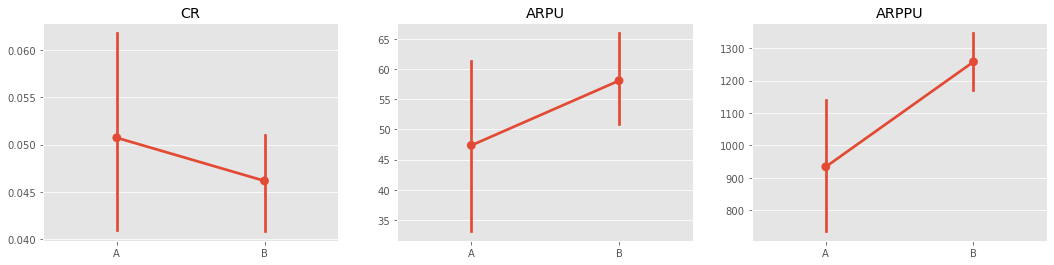

Графики метрик


In [188]:
metrics_viz(groups_add)